# Klasyfikator znaków drogowych
Celem ćwiczenia jest budowa prostego klasyfikatora znaków drogowych z wykorzystniem konwolucyjnych sieci neuronowych. Klasyfikator umożliwi rozpoznawanie 43 różnych znaków drogowych.
Do realizacji zadania zostanie wykorzystna biblioteka [Keras](https://keras.io) oraz [TensorFlow](https://www.tensorflow.org) umożliwiające szybkie i łatwe tworzenie, uczenie i testowanie sieci neuronowych. 



# Realizacja ćwiczenia

Ćwiczenie polega na realizacji kodu w przygotowanym notatniku Jupiter. Kod wykonywany jest w środowisku Google Colaboratory. Środowiski Google Colaboratory umożliwa realizację złożonych obliczeń z wykorzystaniem jednostek obliczeniowych GPU. W przypadku sieci neuronowych, wykorzystanie GPU w sposób znaczący przyśpieszcza trenowanie sieci neuronowej.

W celu skorzystania z układów GPU w obliczeniach należy z menu "Środowisko wykonawcze" => "Zmień typ środowiska wykonawczego" wybrać w polu "Akceleratro sprzętowy" wartość "GPU".

W trakcie realizacji ćwiczenia należy przetesotwać działanie klasyfikatora znaków drogowych który wykorzystuje dwa rodzaje sieci (funkcje model_v1 i model_v2). Po poporwanym wytrenownaiu sieci należy sprawdzić ich działania na kilku przykładowych zdjęciach zawierających znaki drogowe i ocenić jakość działania sieci neurnowej.

# Pobieranie danych
Do nauki sieci wykorzystany zostanie przykładowy zbiór zdjęć znaków drogowych.

Zbiór znaków można pobrać z adresu [https://bitbucket.org/jadslim/german-traffic-signs](https://bitbucket.org/jadslim/german-traffic-signs)
Zbiór danych zawiera różne zdjęcia znaków drogowych podzielno na trzy podzbiory: dane uczące, walidacyjne i do testowania. Zaletą pobranego zbioru danych jest to, że każde zdjęcie przedstawiające znak drogowy zostało również prawidłowo opisane poprzez podanie jakie rodzaju znaku zawiera.

W środowisku Google Colaboratory można wykonywać instrukcje powłoki (np. `ls`, `mkdir`) poprzedzając komendy znakiem wykrzyknika - **`!`.**

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


W rezultacie powinny zostać pobrane pliki:
*   signnames.csv
*   test.p
*   train.p
*   valid.p

Poprawność pobranych danych można sprawdzić następującą komendą `ls` w wyniku której powinniśmy dostać listę pobranych plików (4 pliki). Brak takiej listy oznacza, że dane nie zostały pobrane prawidłowo. Zdjęcia znaków przed zapisaniem zostały zserializowane za pomocą modułu [pickle](https://docs.python.org/3/library/pickle.html).

In [3]:
!ls german-traffic-signs -lh

total 153M
-rw-r--r-- 1 root root  999 Jun 13 16:41 signnames.csv
-rw-r--r-- 1 root root  38M Jun 13 16:41 test.p
-rw-r--r-- 1 root root 103M Jun 13 16:41 train.p
-rw-r--r-- 1 root root  13M Jun 13 16:41 valid.p


# Import bibliotek
Następnym krokiem jest zaimportowanie wszystkich niezbędnych bibliotek.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
import requests
from PIL import Image

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline
np.random.seed(0)

# Przygotowanie danych

Do nauki sieci neuronowych wykorzystywane są trzy zbiory danych:
* zbiór danych uczących
* zbiór danych walidacyjnych
* zbiór danych testowych

Spośród tych trzech zbiorów, najliczniejszy powinien być zbiór danych uczących. Należy również zadbać o to aby był on najbardziej reprezentatywny tj. zawierał wszystkie możliwe obrazki które zawierają cechy które chcemy rozpoznawać i klasyfikować za pomocą sieci neuronowej. Również, wszystkie rodzaje znaków które chcemy rozpoznawać za pomocą sieci neuronowej powinny być reprezentowane przez w miarę taką samą liczbę zdjęć.

Należy zawsze pamiętać iż sieć neuronowa działa tak dobrze jakimi danymi została wytrenowana.

Poniższy kod wczytuje zdjęcia znaków z poszczególnych plików oraz deserializuje je do pojedyńczych obrazków tak aby mogły zostać dalej wykorzystane.


In [4]:
# Train data
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

# Valid data
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# Test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

# Signname
sign_name = pd.read_csv('german-traffic-signs/signnames.csv')

Wczytane dane do zmiennych `traind_data`, `val_data`, `test_data` - są typu słownikowego (ang. dictionary) które zawierając następujące klucze:
* `feature` - zdjęcie znaku
* `labels` - numer typu znaku który odpowiada jego nazwie zapisanej w pliku signnames.cs.

Wywołanie komendy `print(X_train.shape)` zwraca wymiary tablicy jaka została utworzona z wczytanych danych. W naszym przypadku dla zmiennej `X_train` widzimy, że zawiera ona 34799 elementów którymi są tablice o wymiarach 32x32 i trzech kanałach. Rozmiary poszczególnych tablic wynikają z rozmiarów zdjęć znaków (32x32 piksele) oraz tego, że są one kolorowe (zawierają trzy kanały kolorów RGB). 



In [5]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)
(34799,)


## Sprawdzenie poprawności danych

Jedną z dobrych praktyk jest sprawdzanie czy dane które będziemy wykorzystywać w dalszej części prac mają poprawne rozmiary. Można to zrealizować np. z pomocą funkcji [`assert`](https://www.tutorialspoint.com/python/assertions_in_python.htm).

In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

## Analiza wczytanych danych

W kolejnym kroku dokonany zostanie przegląd wczytanych danych. Poniższy kody wyświetla po 5 losowo wybranych znaków z każdego typu. Zlicza również całkowitą liczbę typów znaków i prezentuje ją na ostatnim wykresie.

In [ ]:
# Tabeli przechowuje liczbe znakow z kazdego typu  
num_of_samples=[]
 
cols = 5

# Liczba rodziajów znaków
num_classes = sign_name.shape[0]
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
  for j, row in sign_name.iterrows():
    # Z zbioru treningowego wybieramy te znaki które są sklasyfikowane jako j-typ znaku
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

**Zadanie**
Napisz kod który wyświetla losowy wybrany znak ze zbioru uczącego wraz z jego typem.

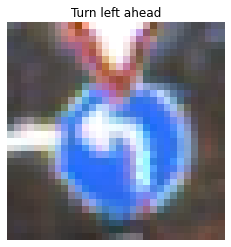

In [25]:
j = 34
x_selected = X_train[y_train == j]
title = sign_name['SignName'][j]
plt.imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
plt.axis("off")
plt.title(title)
plt.show()

Jak można zaobserować zbiór uczący zawiera zdjęcia znaków wykonane w różnych warunkach np. zmienne oświetelenie. W celu bardziej efektywnego wykorzystania danych do uczenia się sieci poszczególne zdjęcia powinny zostać podane dodatkowej obróbce, tak aby zminimalizować wpływ warunków zewnętrznych w jakich zostały zrealizowane a równocześnie uwypuklić cech charaktyrystyczne znaków - tak aby finalnie sieć nauczyła się rozpznawać typu znaków poprawnie.

Jednym z parametrów zdjęcia czułym na warunki zewnętrzne jest np. kolor. Zdjęcie znaku wykonane przy niewystarczającym oświetleniu jest ciemnie i informacja o kolorze jest mało wiarygodna. Z tego też powodu pierwszą operacją będzie konwersja zdjęć do zdjęć monochromatycznych. Dodatkowo konwersja zdjęć kolorowych do postaci monochromatycznej umożliwa zredukowanie wymiaru danych poszczególnych zdjęć z 32x32x3 na 32x32x1.

Główną cechą znaków drogowych są ich kształty oraz krzywe dlatego też sieć neuronowa powinna "nauczyć" sie przede wszystkim rozpoznawania tych cech.

Kolejną operacją jaką poddamy zdjęcia znaków będzie zwiększenie ich kontrastu za pomocą metody [wyrówniania histogramu](https://pl.wikipedia.org/wiki/Wyr%C3%B3wnanie_histogramu).

Poniższy kod można wykonać kilkukrotnie tak aby zaobserwować ja działają filtry na zdjęcia znaków wykonane w różnych warunkach.

Grayscale shape image: (32, 32)
Equalize shape image: (32, 32)


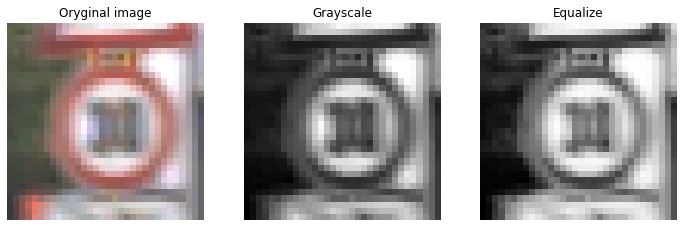

In [28]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

sign_index = random.randint(0, X_train.shape[0] - 1)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(X_train[sign_index])
plt.title("Oryginal image")
plt.axis("off")

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[sign_index])
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.title("Grayscale")
plt.axis("off")
print("Grayscale shape image: " + str(img.shape))

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.subplot(133)
plt.imshow(img, 'gray')
plt.title('Equalize')
plt.axis("off")
print("Equalize shape image: " + str(img.shape))

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

# Zastosowany filtrów obrazów do wszystich danych
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

In [30]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)

# https://keras.io/api/utils/python_utils/#to_categorical-function
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# Sieć neuronowa

## Architektura sieci

Poniższe dwie funkcje definują dwie sieci o różnej budowie. Sieć zdefiniowana przez funkcję `model_v1` jest siecią prostszą (mniej warstw i parametrów), natomiast sieć `model_v2` jest siecią bardziej rozbudowaną.

In [31]:
def model_v1():
  model = Sequential()

  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(15, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# create model v2
def model_v2():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Wybraną sieć tworzymy wywołując odpowiednią funkcję która ją buduje. Parametry sieci, szczegóły jej budowy możemy odczytać za pomocą funkcji `model.summary()`.

In [32]:
model = model_v2()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Uczenie sieci

Do nauki sieci służy metoda `fit`. Jako jej parametry wejściowe podajemy zbiory danych uczących, oraz walidujacych. Określamy liczbę epok a także maksymlaną ilość obrazów które są przetwarzane w jednej iteracji. Dokładnie wyjaśnienie wszystkich parametrów wejściwoych metody `fit` można znaleźć pod adresem [https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [33]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 16s 42ms/step - loss: 2.1944 - accuracy: 0.4055 - val_loss: 0.5634 - val_accuracy: 0.8367
Epoch 2/10
87/87 [==============================] - 2s 27ms/step - loss: 0.4305 - accuracy: 0.8697 - val_loss: 0.2529 - val_accuracy: 0.9229
Epoch 3/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1958 - accuracy: 0.9405 - val_loss: 0.1793 - val_accuracy: 0.9463
Epoch 4/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1275 - accuracy: 0.9612 - val_loss: 0.1398 - val_accuracy: 0.9571
Epoch 5/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0894 - accuracy: 0.9731 - val_loss: 0.1586 - val_accuracy: 0.9549
Epoch 6/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0743 - accuracy: 0.9763 - val_loss: 0.1276 - val_accuracy: 0.9612
Epoch 7/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0623 - accuracy: 0.9808 - val_loss: 0.1482 - val_accuracy: 0.9587
Epoch 8/10
8

## Analiza działania sieci

W wynikiem wywołania metody `fit` jest obiekt klasty `History` który zawiera różne dane opisujące jak dokładnie działa wytrenowana siec.

Wykres pierwszy ("Loss") przedstawia wartość błędu sieci neurnowej w poszczególnych iteracjach trenowania. Wartością porządaną jest aby błąd ten miał jak najmniejszą wartość.

Wykres drugi ("Accuracy") przedstawia dokładność sieci neurnowen w poszczególnych iteracach uczenia się sieci. Wartością porządaną jest aby dokładność miała wartość jak najbardziej zbliżoną do 1.0.

Text(0.5, 0, 'epoch')

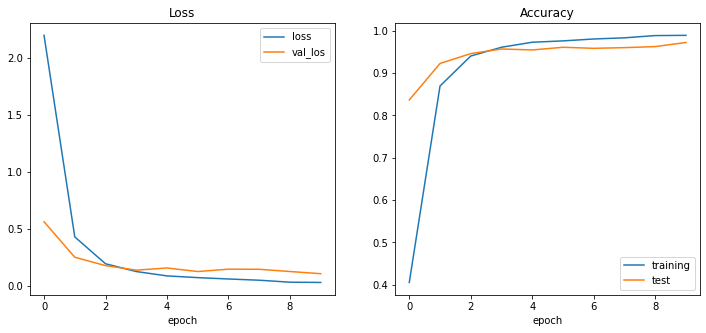

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_los'])
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

Jakość działania sieci można sprawdzić wykorzystując do tego zbiór danych testowy X_test i y_test oraz metody [`evalutate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate). Parametr accuracy daje nam odpowiedź jaki procent znaków ze zbioru testowego zostało rozpoznanych i prawidłow sklasyfikowanych przez naszą sieć.

In [35]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 2s 4ms/step - loss: 0.2205 - accuracy: 0.9453
Test score: 0.22049130499362946
Test accuracy: 0.9452890157699585


Nauczona sieć neuronowa może być równiez testowana za pomocą różny zdjęć znaków tak jak to pokazano na poniższym przykładzie.

In [41]:
model_1 = model_v1()
model_1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)
model_2 = model_v2()
model_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
87/87 [==============================] - 2s 12ms/step - loss: 1.9468 - accuracy: 0.4490 - val_loss: 0.7571 - val_accuracy: 0.7621
Epoch 2/10
87/87 [==============================] - 1s 9ms/step - loss: 0.5783 - accuracy: 0.8170 - val_loss: 0.4864 - val_accuracy: 0.8526
Epoch 3/10
87/87 [==============================] - 1s 9ms/step - loss: 0.3601 - accuracy: 0.8856 - val_loss: 0.3448 - val_accuracy: 0.8921
Epoch 4/10
87/87 [==============================] - 1s 9ms/step - loss: 0.2889 - accuracy: 0.9078 - val_loss: 0.3177 - val_accuracy: 0.9039
Epoch 5/10
87/87 [==============================] - 1s 9ms/step - loss: 0.2442 - accuracy: 0.9220 - val_loss: 0.3835 - val_accuracy: 0.8798
Epoch 6/10
87/87 [==============================] - 1s 10ms/step - loss: 0.2211 - accuracy: 0.9284 - val_loss: 0.2954 - val_accuracy: 0.9145
Epoch 7/10
87/87 [==============================] - 1s 10ms/step - loss: 0.1959 - accuracy: 0.9356 - val_loss: 0.2828 - val_accuracy: 0.9168
Epoch 8/10
87/87 

In [57]:
#predict internet number
urls = [
'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
'https://previews.123rf.com/images/nito500/nito5001603/nito500160300136/54039163-a-triangular-traffic-sign-with-an-exclamation-mark-against-the-blue-sky.jpg',
'https://previews.123rf.com/images/djdarkflower/djdarkflower1512/djdarkflower151200007/50042106-slippery-road-vector-sign.jpg',
'https://previews.123rf.com/images/albasu/albasu1610/albasu161000422/64990426-warning-or-red-attention-elephants.jpg',
'https://previews.123rf.com/images/majestix77/majestix771903/majestix77190300647/132519768-winter-driving-warning-sign-risk-of-snow-and-ice.jpg',
'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg']

fig, axes = plt.subplots(len(urls), 4, figsize=(50, 90))

results = {}
for i, url in enumerate(urls):
  r = requests.get(url, stream=True)
  img = Image.open(r.raw)
  axes[i][0].imshow(img)
  axes[i][0].axis('off')
  # axes[i][0].set_title(i+1)

  # Przygotowanie pobranego zdjęcia znaku drogowego do rozpoznania
  img = np.asarray(img)
  img = cv2.resize(img, (32, 32))
  img = preprocess(img)

  axes[i][1].imshow(img, 'gray')
  axes[i][1].axis('off')

  # Rozpoznanie znaku przez sieć neuronową
  img = img.reshape(1, 32, 32, 1)
  ans1 = np.argmax(model_1.predict(img), axis=-1)
  ans2 = np.argmax(model_2.predict(img), axis=-1)
  results[i+1] = [sign_name['SignName'][ans1[0]], sign_name['SignName'][ans2[0]]]
  axes[i][2].text(.25, .5, sign_name['SignName'][ans1[0]], fontsize=25)
  axes[i][2].axis('off')
  axes[i][3].text(.25, .5, sign_name['SignName'][ans2[0]], fontsize=25)
  axes[i][3].axis('off')

axes[0][0].set_title('Obrazy wejściowe', size=30, fontweight='bold')
axes[0][1].set_title('Przetworzone obrazy', size=30, fontweight='bold')
axes[0][2].set_title('Wynik sieci 1', size=30, fontweight='bold')
axes[0][3].set_title('Wynik sieci 2', size=30, fontweight='bold')
plt.show()

Output hidden; open in https://colab.research.google.com to view.